In [1]:
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from typing import NamedTuple, List

In [2]:
def norm(arr): return arr / np.linalg.norm(arr)

def rotate(p, theta):
    cs = np.cos(theta);
    sn = np.sin(theta);
    
    x, y = p
    
    x2 = x * cs - y * sn; 
    y2 = x * sn + y * cs;
    return np.array([x2, y2])

def rotateLeft(p):
    return rotate(p, np.pi / 2.0)

class Point(NamedTuple):
    x: float
    y: float

# An input line will have points randomly generated around it, the line is specified as two points
class InputLine(NamedTuple):
    start: np.array
    end: np.array
    points: np.array

def make_input_line(start: Point, end: Point, steps=20, spread=0.12) -> InputLine:
    seed = abs(int(10 * (start.x - 2 * end.x + 3 * start.y - 4 * end.y)))  # randomish but stable
    start = np.array(start, dtype=np.float64)
    end = np.array(end, dtype=np.float64)
    
    r = np.random.RandomState(seed)
    dirForward = norm(end - start)
    dirLeft = rotateLeft(dirForward)
    points = []
    for i in range(steps):
        point = start + dirForward * float(i) / float(steps) + dirLeft * (r.rand() - 0.5) * spread
        points.append(point)
    
    return InputLine(start, end, points)

def make_random_line(r) -> InputLine:
    p1 = Point(x=r.rand(), y=r.rand())
    p2 = Point(x=r.rand(), y=r.rand())
    # make sure the line is long enough
    while (np.linalg.norm(np.array(p1) - np.array(p2)) < 0.5):
        p1 = Point(x=r.rand(), y=r.rand())
        p2 = Point(x=r.rand(), y=r.rand())
    return make_input_line(p1, p2)

# An output line is the two parameters of the y = mx + b equation (m=slope, b=y-intercept)
class OutputLine(NamedTuple):
    m: float
    b: float
        
    def y(self, x: float) -> float:
        return self.m * x + self.b

In [3]:
def runOne(solve, line1, line2, ax):
    lines = [line1, line2]

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(True)

    for line in lines:
        x, y = zip(*line.points)
        ax.scatter(x, y, c='g', s=15, edgecolors='none')

    # Run the solver
    all_points = np.array([
        p
        for line in lines
        for p in line.points
    ])
    output_lines = solve(all_points)
    
    # Plot the output lines
    for line in output_lines:
        xs = [0, 1]
        ys = [line.y(x) for x in xs]
        ax.plot(xs, ys, c='r', alpha=0.5)

    for line in lines:
        x, y = zip(*line.points)
        xs = [line.start[0], line.end[0]]
        ys = [line.start[1], line.end[1]]
        ax.plot(xs, ys, c='gray', alpha=0.5)

        
def run(num, solve):
    
    plt.rcParams["figure.figsize"] = (20, num*5)

    r = np.random.RandomState(0)
    for i in range(num):
        
        ax = plt.subplot((num + 1)//2, 2, i + 1, label=str(i))
    
        line1 = make_random_line(r)
        line2 = make_random_line(r)
        runOne(solve, line1, line2, ax)


---
# Solution from here

## Approaches

### Clustering
1. Use clustering algorithm to find clusters in the data
2. Run linear regression on each cluster to get the (coeffecient, intercept) to approximate the clusters.

### Other

Another idea is that the eigen vectors of the highest principal components could be used. There could singular vectors by mapping to the space by the singular vectors could separate the two clusters onthogonal directions.

In [10]:
from typing import (
    List,
    Tuple
)
from sklearn.linear_model import (
    LinearRegression
)
from sklearn.mixture import GaussianMixture
from sklearn.cluster import (
    SpectralClustering,
    DBSCAN,
    Birch
)

In [11]:
def get_clusters(X: np.ndarray, num_clusters: int = 2) -> List[np.ndarray]:
    """Find N clusters in X where N = num_clusters.
    Tested a few clustering algorithms and GaussianMixture performs better.
    
    Args:
        X: data in which to find the clusters
        num_clusters: number of clusters expected to find
    Returns: List of arrays each of which represents a cluster        
    """
    # model = DBSCAN(eps=0.2, min_samples=5)
    # model = SpectralClustering(n_clusters=num_clusters)
    # model = Birch(threshold=0.01, n_clusters=num_clusters)
    model = GaussianMixture(n_components=num_clusters)
    yhat = model.fit_predict(X)
    ids: np.array = np.unique(yhat)
    assert len(ids) == num_clusters

    return [X[yhat == cluster_id] for cluster_id in ids]    

In [12]:
def plot_clusters(X):
    """Find and plot clusters
    Args:
        X: data to find clusters
    """
    for cluster in get_clusters(X):
        plt.scatter(cluster[:, 0], cluster[:, 1])

In [13]:
def get_linear_regression_line(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Run linear regression to find the coeffeicient and intersept to approximate the data
    Args: 
        X: data to approximate
    Returns: (coefficient, intersect)
    """
    x = X[..., 0, np.newaxis]
    y = X[..., 1, np.newaxis]
    
    model = LinearRegression()
    model.fit(x, y)

    coefficient = np.squeeze(model.coef_)
    intersect = np.squeeze(model.intercept_)
    
    return coefficient, intersect

def plot_linear_regression_line(
    coefficient: np.ndarray, 
    intersect: np.ndarray,
    start: np.ndarray = np.array(0.0),
    end:  np.ndarray = np.array(1.0)
):
    """Plot the linea regression line
    """
    x = np.linspace(start, end, num=100)
    y = x * coefficient + intersect
    ax = plt.gca()
    ax.set_xlim([start, end])
    ax.set_ylim([start, end])
    plt.plot(x, y)

In [14]:
##### IMPLEMENT THE solve() FUNCTION HERE #####
def solve(points: np.array) -> List[OutputLine]: 
    
    # Example lines result.
    # Change m & b for each line, by fitting them to the input points.
    clusters = get_clusters(X=points, num_clusters=2)
    m1, b1 = get_linear_regression_line(clusters[0])
    line1 = OutputLine(m=m1, b=b1)

    m2, b2 = get_linear_regression_line(clusters[1])
    line2 = OutputLine(m=m2, b=b2)
    
    return [line1, line2]

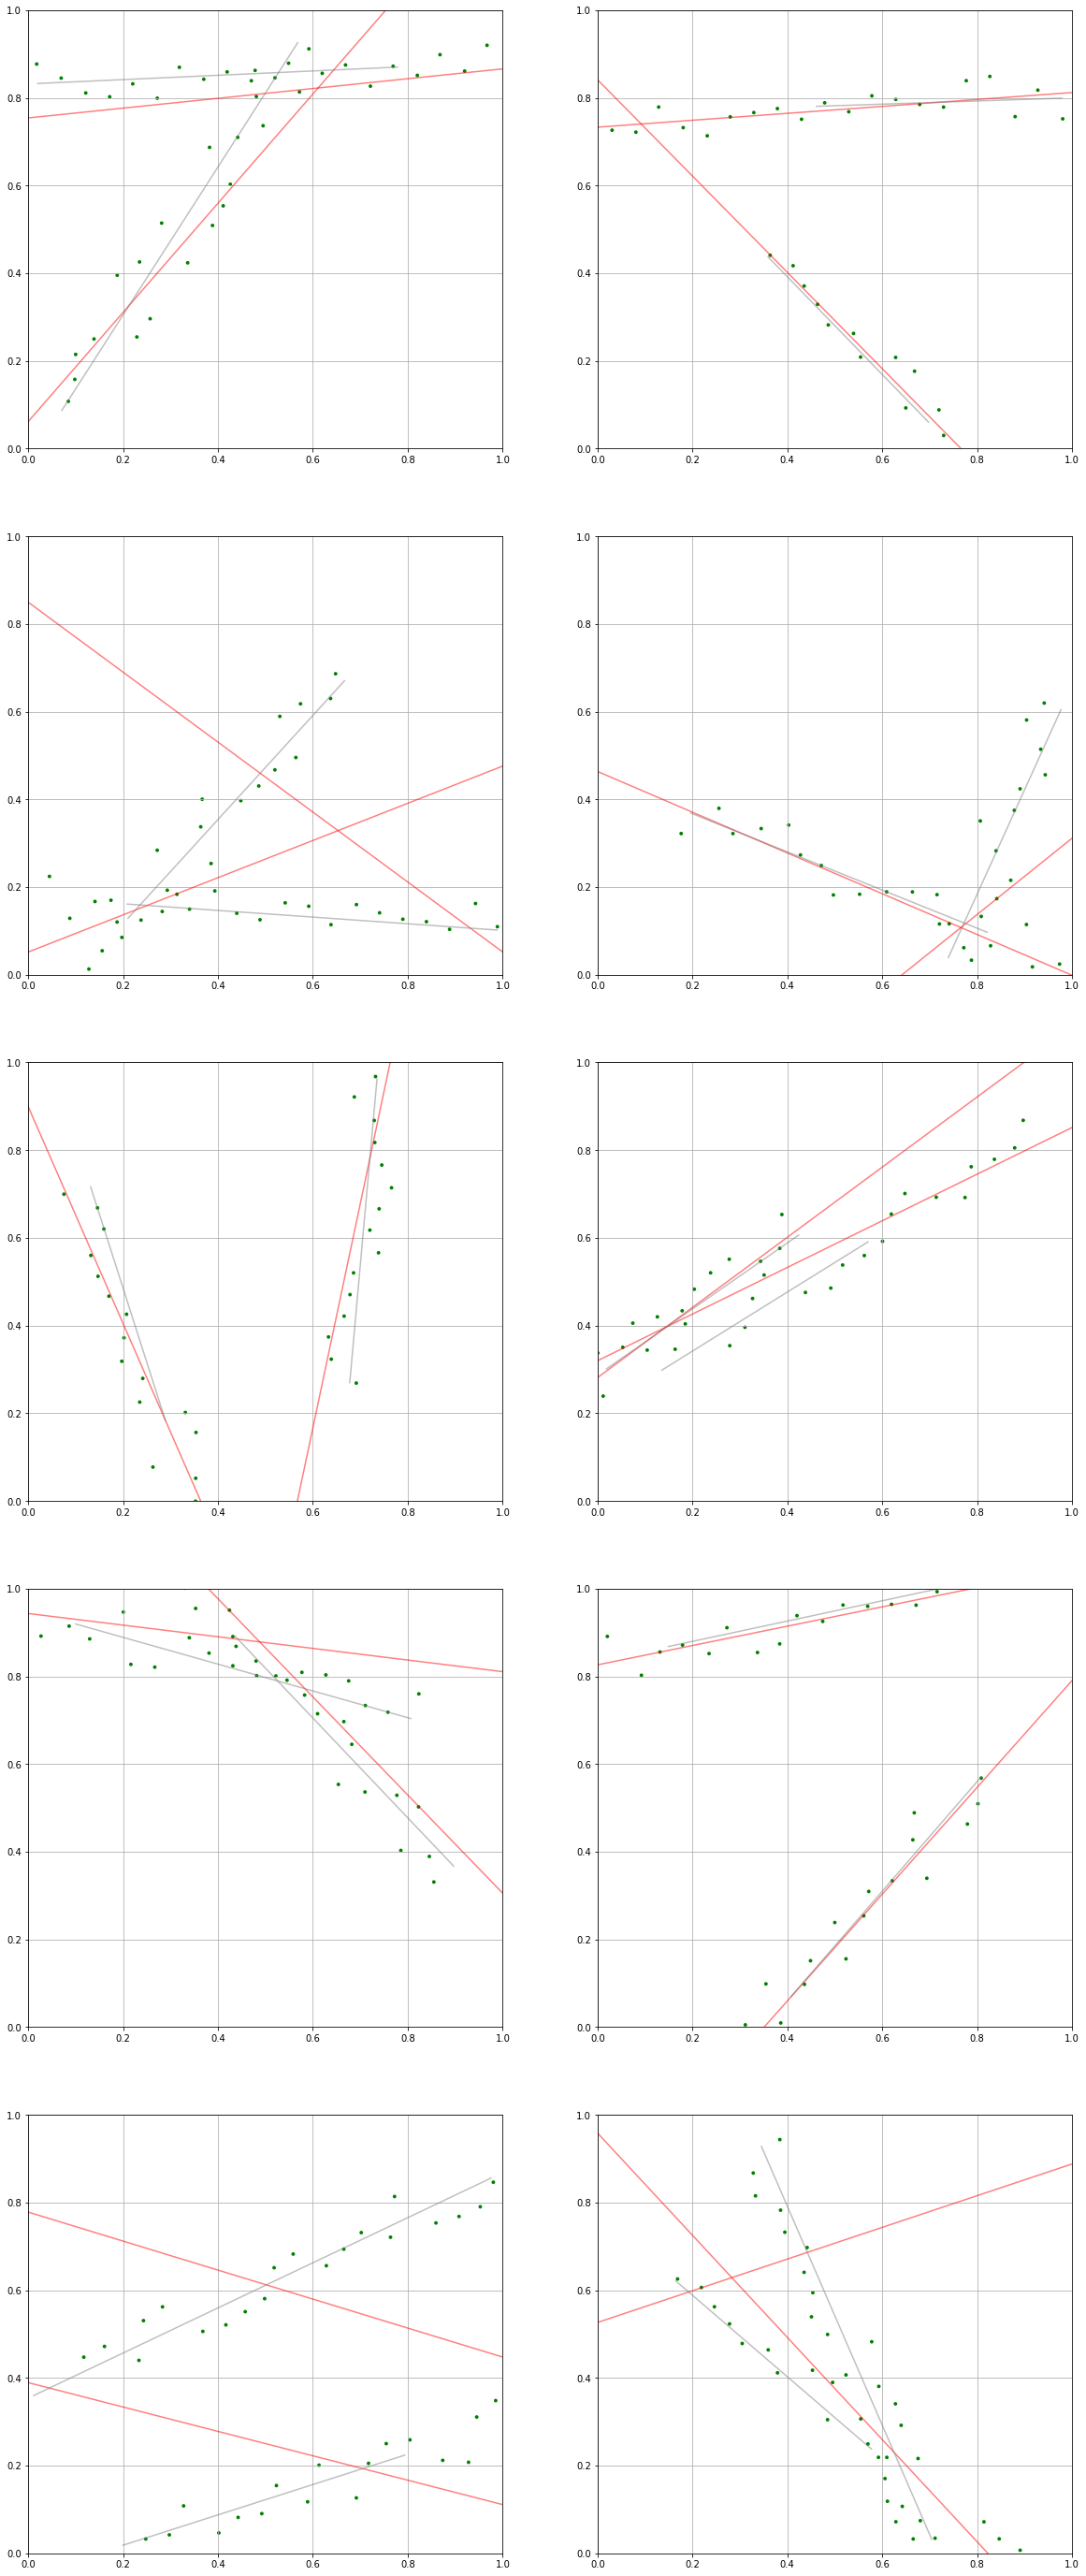

In [15]:
# Runs some simple example cases.
# Original lines used to generate the points shown in grey.
# Solution lines shown in blue.

run(10, solve)